In [16]:
import pandas as pd
import numpy as np
from geopy import distance
from datetime import datetime, timedelta
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt 
import seaborn as sns
import calendar
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from scipy.stats import boxcox
import os

In [5]:
#Import data
customers = pd.read_csv(r'https://raw.githubusercontent.com/PixarJunkie/dsc-672-capstone-project/main/data/olist_customers_dataset.csv')
locations = pd.read_csv(r'https://raw.githubusercontent.com/PixarJunkie/dsc-672-capstone-project/main/data/olist_geolocation_dataset.csv')
items = pd.read_csv(r'https://raw.githubusercontent.com/PixarJunkie/dsc-672-capstone-project/main/data/olist_order_items_dataset.csv')
payments = pd.read_csv(r'https://raw.githubusercontent.com/PixarJunkie/dsc-672-capstone-project/main/data/olist_order_payments_dataset.csv')
reviews = pd.read_csv(r'https://raw.githubusercontent.com/PixarJunkie/dsc-672-capstone-project/main/data/olist_order_reviews_dataset.csv')
orders = pd.read_csv(r'https://raw.githubusercontent.com/PixarJunkie/dsc-672-capstone-project/main/data/olist_orders_dataset.csv')
products = pd.read_csv(r'https://raw.githubusercontent.com/PixarJunkie/dsc-672-capstone-project/main/data/olist_products_dataset.csv')
sellers = pd.read_csv(r'https://raw.githubusercontent.com/PixarJunkie/dsc-672-capstone-project/main/data/olist_sellers_dataset.csv')
product_category = pd.read_csv(r'https://raw.githubusercontent.com/PixarJunkie/dsc-672-capstone-project/main/data/product_category_name_translation.csv')
closed_deals = pd.read_csv(r'https://raw.githubusercontent.com/PixarJunkie/dsc-672-capstone-project/main/data/olist_closed_deals_dataset.csv')
marketing_leads = pd.read_csv(r'https://raw.githubusercontent.com/PixarJunkie/dsc-672-capstone-project/main/data/olist_marketing_qualified_leads_dataset.csv')

### Summary

In [6]:
datasets = [customers, locations, items, payments, reviews, orders, products, sellers, product_category, closed_deals, marketing_leads]
col_names = ['customers', 'locations', 'items', 'payments', 'reviews', 'orders', 'products', 'sellers', 'product_category', 'closed_deals', 'marketing_leads']

#To gather practical information about all datasets 
summary = pd.DataFrame({},)
summary['dataset'] = col_names
summary['cols'] = [', '.join([col for col, null in df.isnull().sum().items() ]) for df in datasets]
summary['cols_no'] = [df.shape[1] for df in datasets]
summary['null_no'] = [df.isnull().sum().sum() for df in datasets]
summary['null_cols_no']  = [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
summary['null_cols'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]


summary.style.background_gradient(cmap = 'coolwarm')

,dataset,cols,cols_no,null_no,null_cols_no,null_cols
0,customers,"customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state",5,0,0,
1,locations,"geolocation_zip_code_prefix, geolocation_lat, geolocation_lng, geolocation_city, geolocation_state",5,0,0,
2,items,"order_id, order_item_id, product_id, seller_id, shipping_limit_date, price, freight_value",7,0,0,
3,payments,"order_id, payment_sequential, payment_type, payment_installments, payment_value",5,0,0,
4,reviews,"review_id, order_id, review_score, review_comment_title, review_comment_message, review_creation_date, review_answer_timestamp",7,146532,2,"review_comment_title, review_comment_message"
5,orders,"order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date",8,4908,3,"order_approved_at, order_delivered_carrier_date, order_delivered_customer_date"
6,products,"product_id, product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm",9,2448,8,"product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm"
7,sellers,"seller_id, seller_zip_code_prefix, seller_city, seller_state",4,0,0,
8,product_category,"product_category_name, product_category_name_english",2,0,0,
9,closed_deals,"mql_id, seller_id, sdr_id, sr_id, won_date, business_segment, lead_type, lead_behaviour_profile, has_company, has_gtin, average_stock, business_type, declared_product_catalog_size, declared_monthly_revenue",14,3300,8,"business_segment, lead_type, lead_behaviour_profile, has_company, has_gtin, average_stock, business_type, declared_product_catalog_size"


### Merge Datasets

In [7]:
#Merging Data
merge_df = pd.merge(orders, payments, on = 'order_id', how = 'left')
merge_df = merge_df.merge(customers, on = 'customer_id', how = 'left')
merge_df = merge_df.merge(items, on = 'order_id', how = 'left') 
merge_df = merge_df.merge(products, on = 'product_id', how = 'left')
merge_df = merge_df.merge(product_category, on = "product_category_name", how = 'left')
final_df = merge_df.merge(sellers, on = 'seller_id', how = 'left')

#Drop NAs, check shape, check NANs
print(final_df.shape)
final_df.dropna(inplace=True) 

#Drop unecessary columns
final_df.drop(['product_category_name'], axis = 1, inplace = True)

(118434, 34)


### Feature Engineering

In [21]:
#Dummy df
dummy_df = final_df.copy()

#Adding Columns
#Change columns to datetime
date_cols = ['order_purchase_timestamp', 'order_delivered_customer_date', 'order_delivered_carrier_date', 'order_estimated_delivery_date', 'shipping_limit_date']
dummy_df[date_cols] = dummy_df[date_cols].apply(pd.to_datetime)

#Create temporal variables variable
dummy_df['order_delivered_month'] = pd.DatetimeIndex(dummy_df.order_purchase_timestamp).month
dummy_df['estimated_delivery_month'] = pd.DatetimeIndex(dummy_df.order_estimated_delivery_date).month
dummy_df['estimated_delivered_days'] = (dummy_df.order_delivered_customer_date - dummy_df.order_estimated_delivery_date).apply(lambda x: x.days)
dummy_df['shipping_limit_carrier_days'] = (dummy_df.order_delivered_carrier_date - dummy_df.shipping_limit_date).apply(lambda x: x.days)

#Create binary late columns
dummy_df['late_to_customer'] = np.where(dummy_df.estimated_delivered_days < 0, 0, 1)
dummy_df['late_to_carrier'] = np.where(dummy_df.estimated_delivered_days < 0, 0, 1)

#Months with major holidays
holiday_months = {1: 1, 2: 0, 3: 2, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 1, 10: 1, 11: 2, 12: 1}
dummy_df['major_holidays'] = dummy_df.estimated_delivery_month.map(holiday_months)

#Weight per volume derivation 
#Assuming gerneralized volume calc where v = LWH, so w_v = w/LWH
dummy_df['weight_by_volume'] = dummy_df.product_weight_g / (dummy_df.product_length_cm * dummy_df.product_width_cm * dummy_df.product_height_cm)

#Distance 
#Location dict
lat_dict = dict(zip(locations.geolocation_zip_code_prefix, locations.geolocation_lat))
lng_dict = dict(zip(locations.geolocation_zip_code_prefix, locations.geolocation_lng))

#Locations 
dummy_df['customer_lat'] = dummy_df.customer_zip_code_prefix.map(lat_dict)
dummy_df['customer_lng'] = dummy_df.customer_zip_code_prefix.map(lng_dict)
dummy_df['seller_lat'] = dummy_df.seller_zip_code_prefix.map(lat_dict)
dummy_df['seller_lng'] = dummy_df.seller_zip_code_prefix.map(lat_dict)
#Drop rows where zip code returned empty for lat or lng
dummy_df.dropna(subset = ['customer_lat', 'customer_lng', 'seller_lat', 'seller_lng'], how = 'any', inplace = True)
#Zip lat and lng for customer and seller
dummy_df['customer_lat_lng'] = list(zip(dummy_df.customer_lat, dummy_df.customer_lng))
dummy_df['seller_lat_lng'] = list(zip(dummy_df.seller_lat, dummy_df.seller_lng))

#Calculate distance
dummy_df['seller_customer_dist_miles'] = dummy_df.apply(lambda x: distance.distance(x.seller_lat_lng, x.customer_lat_lng).miles, axis = 1)

In [22]:
#Transform features
le = LabelEncoder()

#List of columns to transform
dummy_cols = ['order_status', 'payment_type', 'customer_state', 'customer_city', 'seller_city', 'seller_state', 'product_category_name_english', 'customer_unique_id', 'seller_id', 'product_id']

#Encode features
for col in dummy_cols:
    dummy_df[col] = le.fit_transform(dummy_df[col])

#Drop uneeded columns 
dummy_df.drop(columns = ['order_id', 'order_status', 'customer_id', 'order_purchase_timestamp', 'order_delivered_customer_date', 'order_delivered_carrier_date', 'order_estimated_delivery_date', 'shipping_limit_date', 
                         'order_approved_at', 'customer_lat', 'customer_lng', 'seller_lat', 'seller_lng', 'customer_lat_lng', 'seller_lat_lng', 'product_name_lenght', 'product_photos_qty', 
                         'product_description_lenght'], axis = 1, inplace = True)

### Histogram/Density Plots

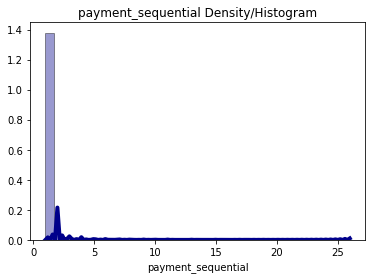

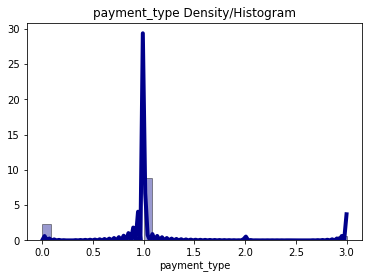

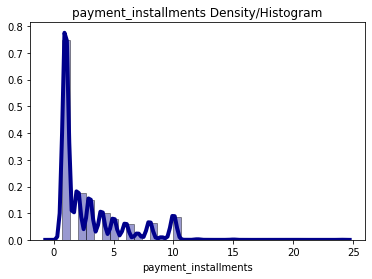

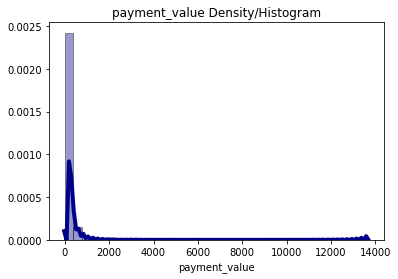

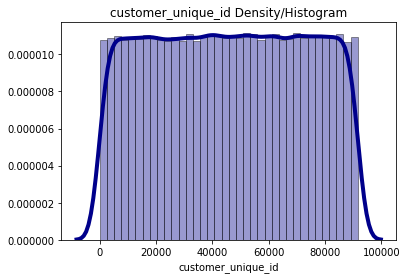

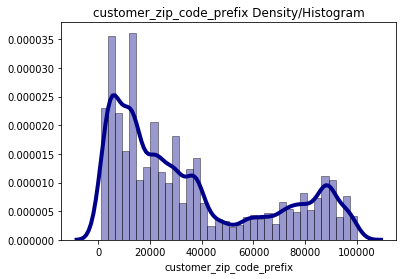

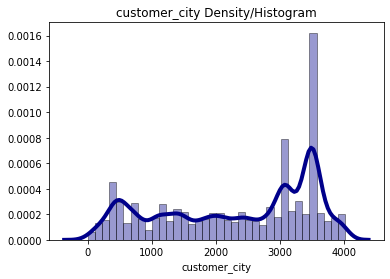

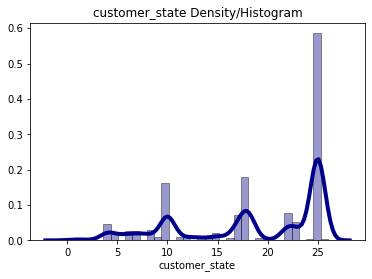

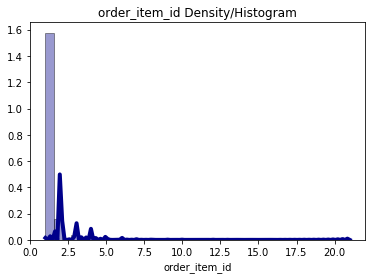

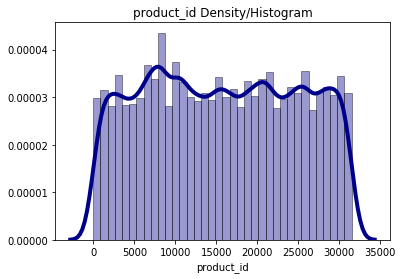

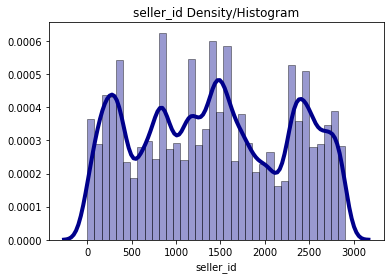

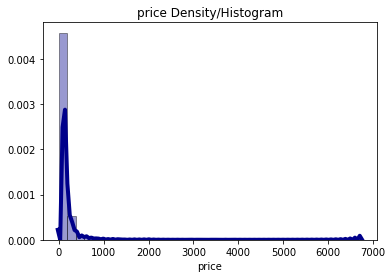

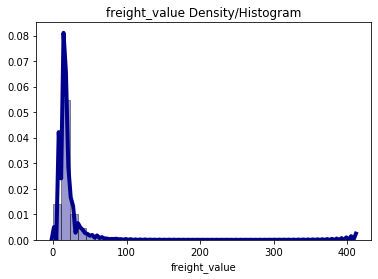

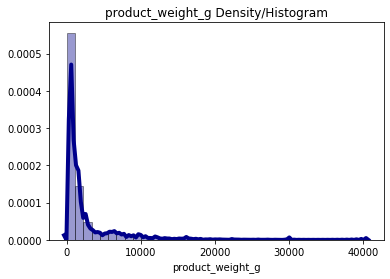

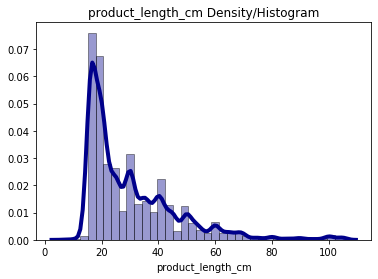

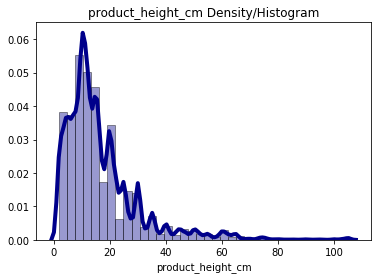

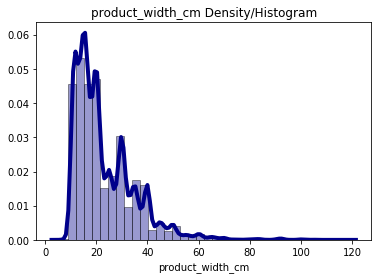

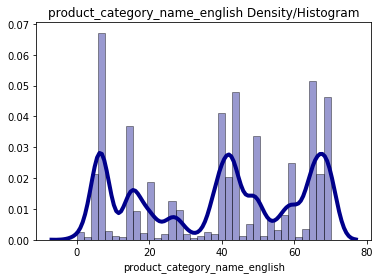

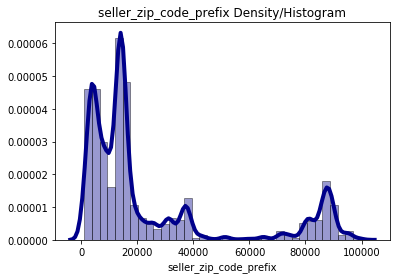

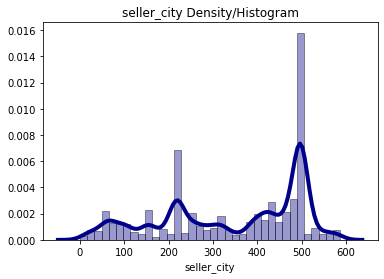

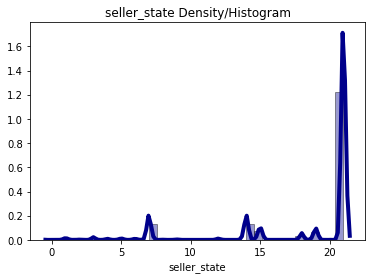

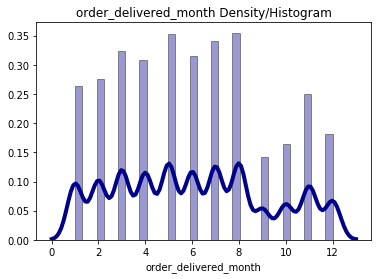

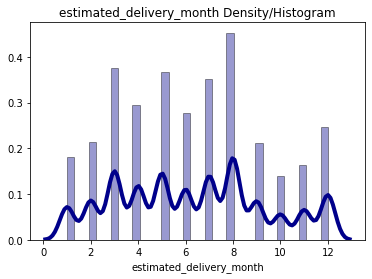

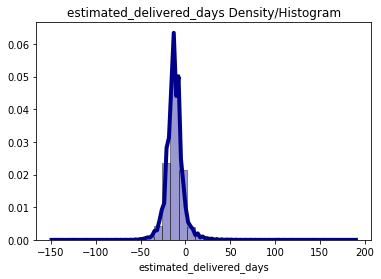

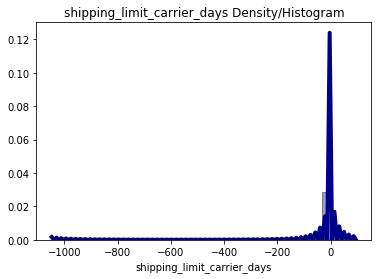

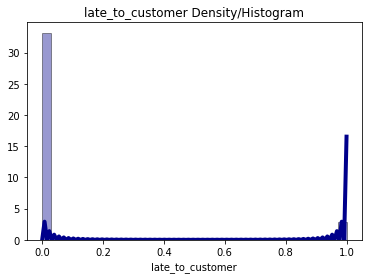

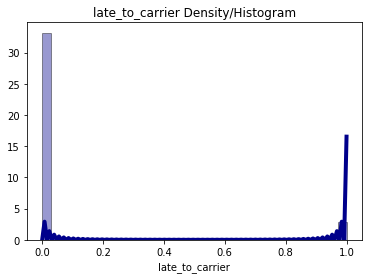

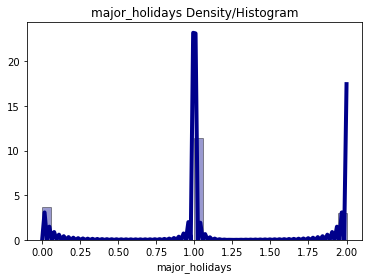

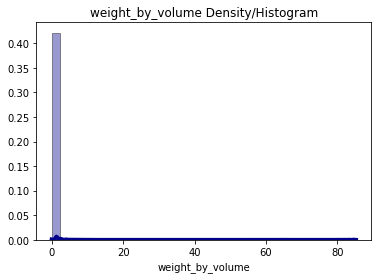

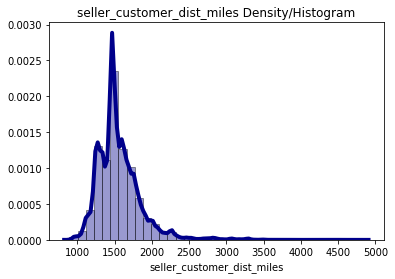

In [14]:
#Density plots and histograms of data2 columns
for col in dummy_df.columns:
    sns.distplot(dummy_df['%s' %(col)], hist = True, kde = True, 
                 bins = int(180 / 5), color = 'darkblue', 
                 hist_kws = {'edgecolor': 'black'},
                 kde_kws = {'linewidth': 4}).set_title(str(col) + ' Density/Histogram')
    plt.show() 

### Transform Skewed Columns

In [23]:
dummy_df2 = dummy_df.copy()

In [24]:
#Log Transform right-skewed columns that are not ID columns
right_skewed_cols = ['payment_value', 'price', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'weight_by_volume']
#Log transform
for col in right_skewed_cols: 
    dummy_df2[col] = np.log10(dummy_df2[col])

C:\Users\kbchi\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


### EDA 

In [ ]:
#Density plots and histograms of data2 columns
for col in final_df.columns:
    sns.distplot(data2['%s' %(col)], hist = True, kde = True, 
                 bins = int(180 / 5), color = 'darkblue', 
                 hist_kws = {'edgecolor': 'black'},
                 kde_kws = {'linewidth': 4}).set_title(str(col) + ' Density/Histogram')
    plt.show() 

Text(0.5, 1.0, 'Purchase by Month')

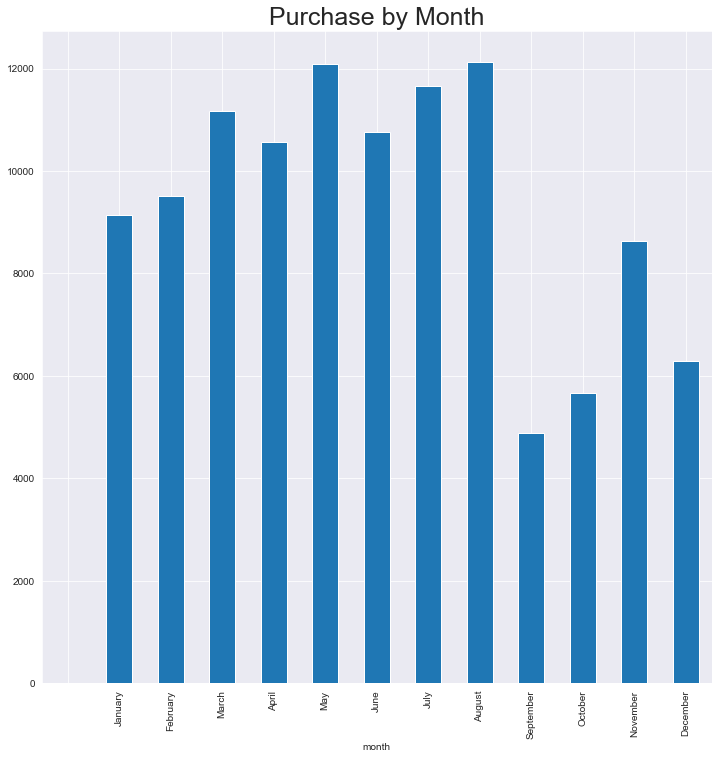

In [56]:
#Purchases by month
#Convert to datetime
final_df.order_purchase_timestamp_x = pd.to_datetime(final_df.order_purchase_timestamp_x)
final_df['month'] = pd.Series(pd.Categorical(final_df.order_purchase_timestamp_x.dt.month_name(), categories = list(calendar.month_name)))
#Groupby and plot
final_df.groupby('month').size().plot(kind = 'bar', figsize=(12,12))
plt.title('Purchase by Month',fontsize=25)

Text(0.5, 1.0, 'Purchases by Month')

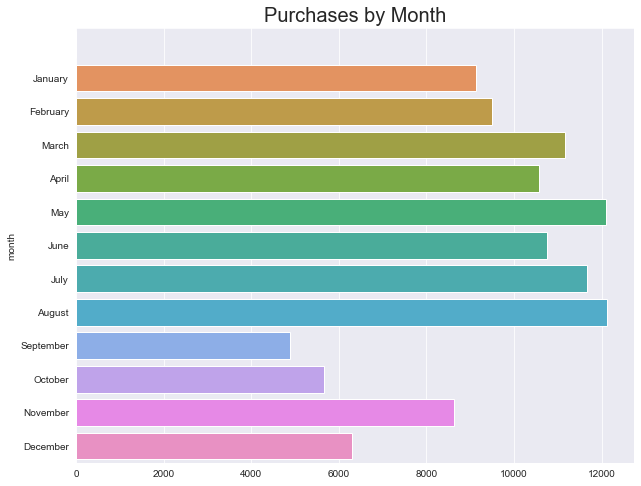

In [42]:
month = final_df.groupby('month').size().sort_values()
fig = plt.figure(figsize=(10,8))
sns.set_style("darkgrid")
sns.barplot(y = month.index, x = month.values)
plt.title('Purchases by Month',fontsize = 20)

Text(0.5, 1.0, 'Payment Types')

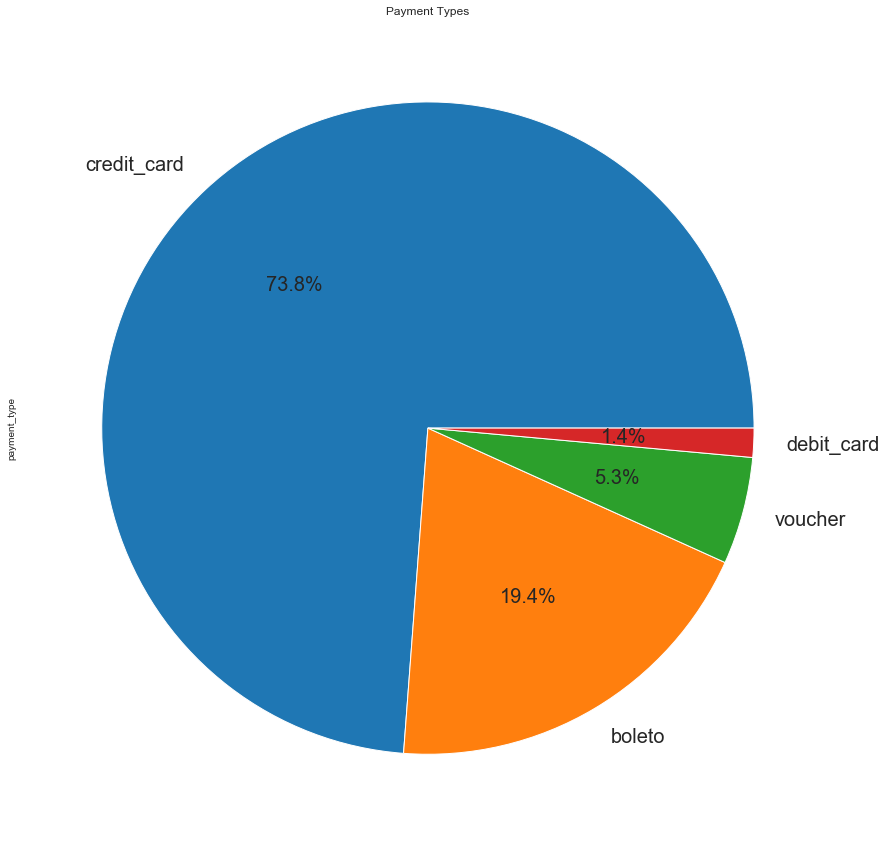

In [49]:
#Payment type
final_df.payment_type.value_counts().plot(kind = 'pie', autopct = '%1.1f%%', fontsize = 20, figsize = (15, 15))
plt.title('Payment Types')

In [51]:
#Top Regions 
regions = final_df.customer_state.value_counts()
regions

SP    48511
RJ    14873
MG    13415
RS     6380
PR     5868
SC     4223
BA     3930
DF     2421
GO     2372
ES     2307
PE     1828
CE     1498
PA     1090
MT     1079
MS      835
MA      817
PB      623
RN      561
PI      553
AL      441
SE      386
TO      334
RO      281
AM      169
AC       94
AP       83
RR       46
Name: customer_state, dtype: int64

Text(0.5, 1.0, 'Sales by Regions')

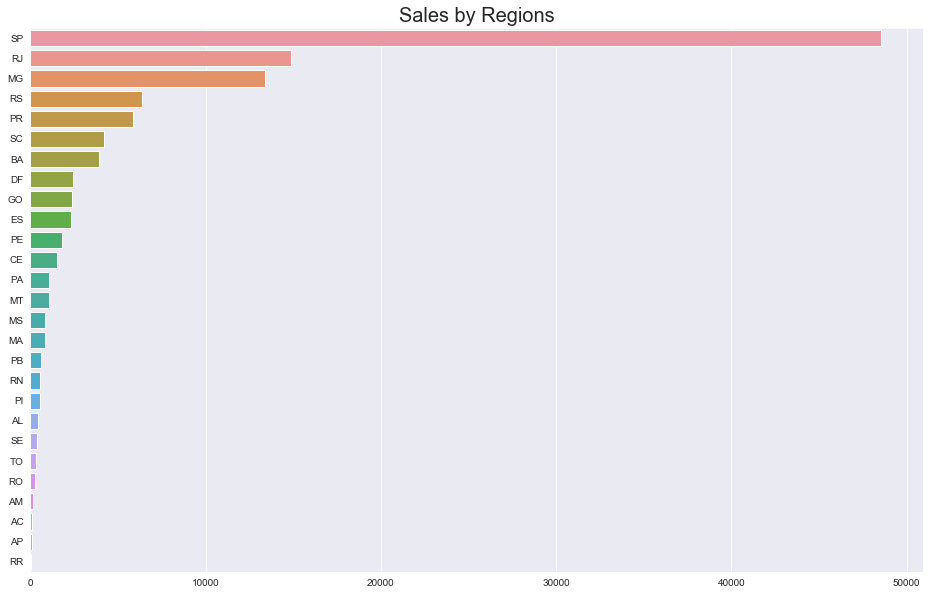

In [65]:
fig = plt.figure(figsize = (16, 10))
sns.set_style("darkgrid")
sns.barplot(y = regions.index, x = regions.values)
plt.title('Sales by Regions', fontsize = 20)

Text(0.5, 1.0, 'Top 20 Products')

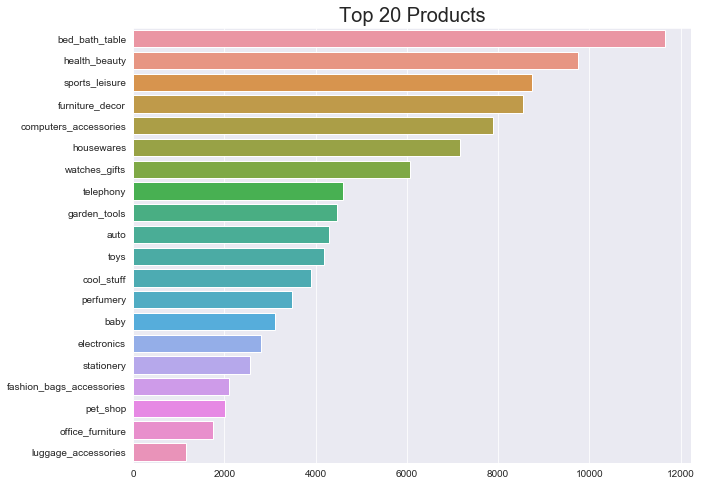

In [64]:
#Products
top_20 = final_df.product_category_name_english.value_counts()[:20]

fig=plt.figure(figsize = (10, 8))
sns.set_style('darkgrid')
sns.barplot(y = top_20.index, x = top_20.values)
plt.title('Top 20 Products', fontsize = 20)

Text(0.5, 1.0, 'Price Distribution')

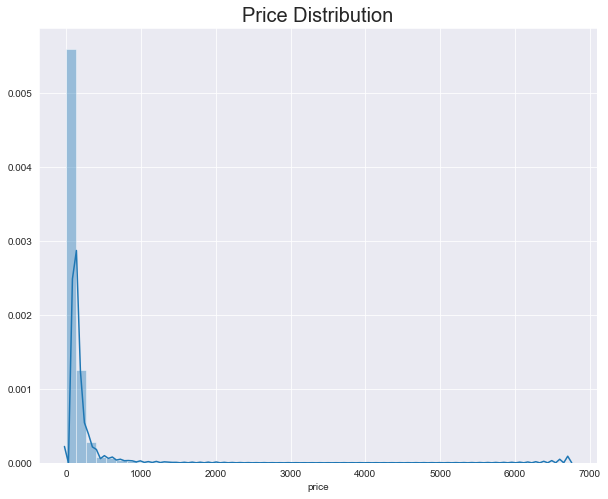

In [69]:
#Price 
fig = plt.figure(figsize = (10,8))
sns.set_style("darkgrid")
sns.distplot(final_df.price)
plt.title('Price Distribution', fontsize = 20)

# Late Delivery Analysis

In [42]:
late_df = dummy_df[dummy_df.late == 1]

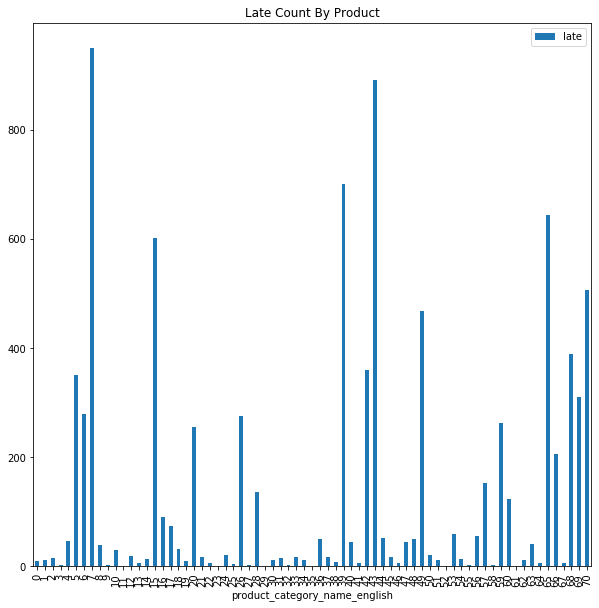

In [13]:
#Late orders by product category
fig = plt.figure()
fig.set_size_inches(10, 10)
plt.title('Late Count By Product')
dummy_df.groupby('product_category_name_english')['late'].sum().plot(kind = 'bar', legend = True)

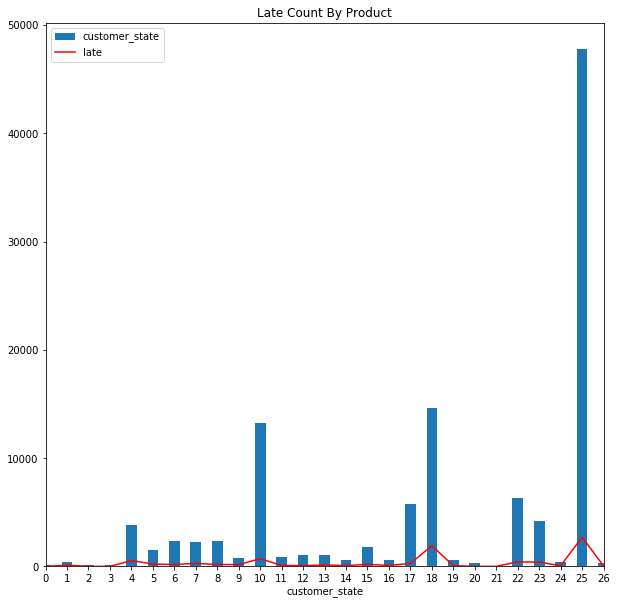

In [46]:
#Late orders by customer state
fig = plt.figure()
fig.set_size_inches(10, 10)
plt.title('Late Count By Product')
dummy_df.groupby('customer_state')['customer_state'].count().plot(kind = 'bar', legend = True)
dummy_df.groupby('customer_state')['late'].sum().plot(kind = 'line', color = 'red', legend = True)
plt.show()

# Correlation Analysis

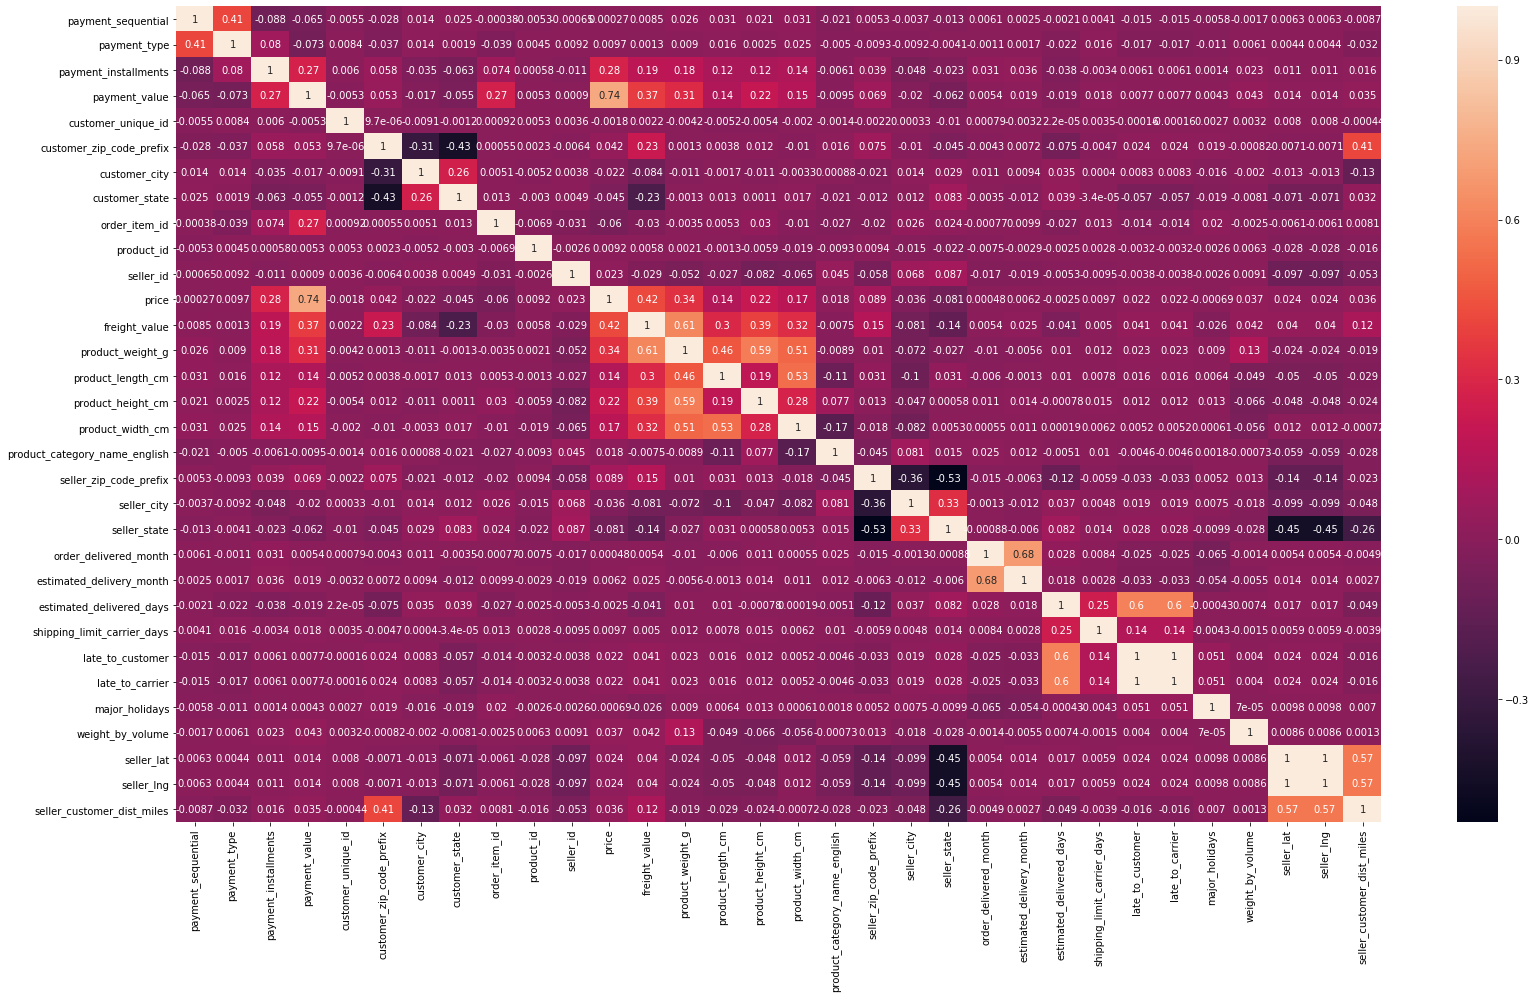

In [221]:
fig = plt.figure()
fig.set_size_inches(27, 15)
corrMatrix = dummy_df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()